# DCGAN

In [1]:
import itertools
import math

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from IPython import display

In [2]:
config = {
    'lr':0.0002,
    'n_epoch':1,
    'batch_size':64,
}

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

In [4]:
# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),
            # nn.Dropout2d(0.25),
            nn.Conv2d(256, 1, 4, 2, 1, bias=False),
             nn.LeakyReLU(0.2,inplace=True),
            nn.Sigmoid()
        )
    def forward(self,x):
        output = self.model(x)
        output = output.view(-1,1).squeeze(1)
        return output

In [6]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 1, 1, 1, 2, bias=False),
                nn.Tanh()
            )

    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
D = Discriminator().cuda()
G = Generator().cuda()
D.apply(weights_init)
G.apply(weights_init)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)

In [8]:
Loss = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas = (0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas = (0.5, 0.999))

In [9]:
# Draw samples from the input distribution to inspect the generation on training
fixed_number_samples = 16
fixed_noise = Variable(torch.randn(fixed_number_samples, 100,1,1)).cuda()

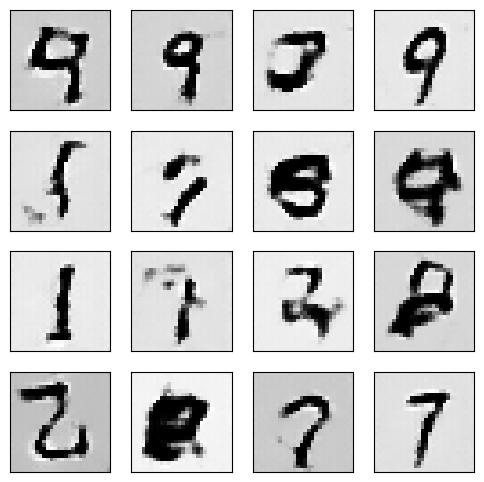

d_loss: tensor(0.5754, device='cuda:0', grad_fn=<AddBackward0>) g_loss: tensor(1.2649, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


AttributeError: 'Figure' object has no attribute 'close'

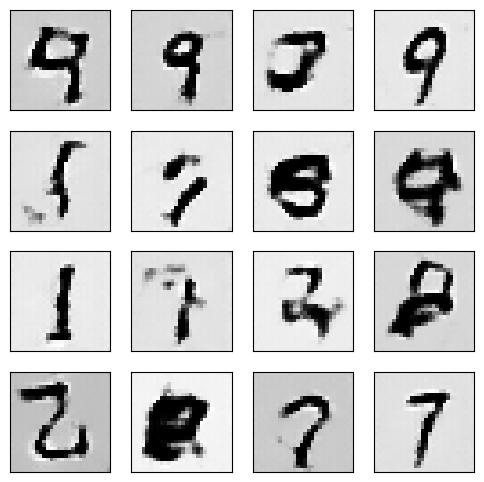

In [10]:
size_figure_grid = int(math.sqrt(fixed_number_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

for epoch in range(config['n_epoch']):
    for n, (batch_imgs, _) in enumerate(train_loader):

        # Train discriminator
        D.zero_grad()
        real_labels = torch.ones(batch_imgs.size()[0])
        real_out = D(batch_imgs.cuda())
        real_loss = Loss(real_out.cuda(),real_labels.cuda())

        fake_labels = torch.zeros(batch_imgs.size()[0])
        noise_vectors = torch.randn(batch_imgs.size()[0],100,1,1)
        fake_imgs = G(noise_vectors.cuda())
        fake_out = D(fake_imgs.cuda())
        fake_loss = Loss(fake_out.cuda(),fake_labels.cuda())

        d_loss = real_loss+fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        G.zero_grad()
        noise_vectors = torch.randn(batch_imgs.size()[0],100,1,1)
        fake_imgs = G(noise_vectors.cuda())
        fake_out = D(fake_imgs.cuda())

        g_loss = Loss(fake_out.cuda(),real_labels.cuda())
        g_loss.backward()
        g_optimizer.step()

        if (n+1) % 100 == 0:
            test_images = G(fixed_noise.cuda())
            test_images = test_images.data.cpu().numpy().reshape(test_images.size()[0],28, 28)
            for k in range(fixed_number_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k], cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())

            print('d_loss:',d_loss,'g_loss:',g_loss)

fig.close()



### Observation
DCGAN seems to have the same problem as of GAN. The loss still oscillates and you don't know when the model will converge. Sometimes the images look good, and sometimes mode collapse occurs. The training of DCGAN takes longer time than of GAN per epoch, but from my observation, as the epoch increases (5,10,15,25,...), the generator does not improve and even get worse in which the generator could not escape from mode collapse. 

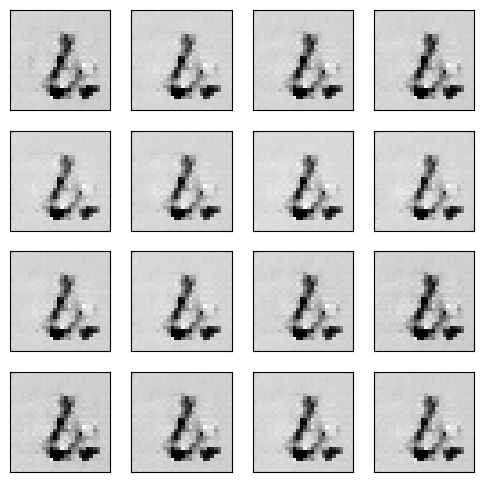

## References
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, https://arxiv.org/abs/1511.06434
- https://www.kaggle.com/code/tjac718/dcgan-on-mnist-dataset-using-pytorch